In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from collections import Counter
#import cv2

import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Embedding, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras import losses
from keras import metrics

# Класифікація даних

https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset

In [2]:
data_array = pd.read_csv('smoke_detection_iot.csv',delimiter=',')

In [3]:
del data_array["Unnamed: 0"]
var=["TVOC[ppb]", "eCO2[ppm]", "PM1.0", "PM2.5", "NC0.5", "NC1.0", "NC2.5", "Humidity[%]"]
for i in range(len(var)):
    x=var[i]
    q_hi  = data_array[x].quantile(0.95)
    data_array=data_array[data_array[x]<q_hi]

var = ["Humidity[%]", "Raw H2", "Pressure[hPa]", "Raw Ethanol"]
for i in range(len(var)):
    x=var[i]
    q_low  = data_array[x].quantile(0.05)
    data_array=data_array[data_array[x]>q_low]
data_array

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
478,1654733809,25.194,50.02,8,400,12777,19790,939.828,0.10,0.12,0.67,0.126,0.015,478,0
482,1654733813,25.223,49.64,9,400,12779,19792,939.812,0.17,0.19,1.10,0.204,0.024,482,0
483,1654733814,25.230,49.62,3,400,12780,19794,939.827,0.18,0.18,1.21,0.188,0.004,483,0
496,1654733827,25.321,54.76,19,400,12779,19779,939.815,0.25,0.26,1.70,0.265,0.006,496,0
497,1654733828,25.328,55.01,11,400,12776,19772,939.815,0.24,0.25,1.67,0.261,0.006,497,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60568,1655127990,12.101,44.62,0,400,13388,21195,937.448,1.90,1.97,13.07,2.038,0.046,3682,0
60569,1655127991,12.104,44.59,0,400,13406,21235,937.454,1.92,1.99,13.18,2.056,0.046,3683,0
60570,1655127992,12.108,43.82,0,400,13402,21247,937.462,1.93,2.00,13.27,2.069,0.047,3684,0
60571,1655127993,12.112,42.82,0,400,13403,21247,937.468,1.91,1.99,13.15,2.051,0.046,3685,0


In [4]:
data_without_y = data_array.copy()
del data_without_y["Fire Alarm"]

In [5]:
variables=["UTC", "Temperature[C]", "Humidity[%]", "TVOC[ppb]", "eCO2[ppm]", "Raw H2", "Raw Ethanol", "Pressure[hPa]", "PM1.0", "PM2.5", "NC0.5", "NC1.0", "NC2.5", "CNT"]
scaler = StandardScaler()
data_without_y[variables] = scaler.fit_transform(data_without_y[variables])
data_without_y

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
478,-0.621609,0.754027,-0.223219,-1.486356,-0.46422,-1.598553,0.285942,1.613402,-2.264430,-2.238350,-2.268853,-2.235135,-1.386239,-1.641414
482,-0.621532,0.756418,-0.357690,-1.484426,-0.46422,-1.583055,0.291627,1.581057,-2.145112,-2.123490,-2.162363,-2.111239,-0.751289,-1.640869
483,-0.621513,0.756996,-0.364768,-1.496002,-0.46422,-1.575305,0.297311,1.611381,-2.128067,-2.139898,-2.135122,-2.136654,-2.162289,-1.640732
496,-0.621263,0.764501,1.454133,-1.465133,-0.46422,-1.583055,0.254677,1.587122,-2.008748,-2.008630,-2.013773,-2.014347,-2.021189,-1.638960
497,-0.621244,0.765078,1.542601,-1.480568,-0.46422,-1.606303,0.234781,1.587122,-2.025794,-2.025039,-2.021202,-2.020700,-2.021189,-1.638824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60568,6.952497,-0.325809,-2.134127,-1.501790,-0.46422,3.136327,4.279359,-3.197984,0.803752,0.797230,0.802015,0.801895,0.800811,-1.204554
60569,6.952516,-0.325562,-2.144743,-1.501790,-0.46422,3.275816,4.393051,-3.185855,0.837843,0.830047,0.829257,0.830486,0.800811,-1.204417
60570,6.952535,-0.325232,-2.417224,-1.501790,-0.46422,3.244818,4.427158,-3.169682,0.854889,0.846456,0.851545,0.851135,0.871361,-1.204281
60571,6.952555,-0.324902,-2.771096,-1.501790,-0.46422,3.252567,4.427158,-3.157552,0.820798,0.830047,0.821827,0.822544,0.800811,-1.204145


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data_without_y,     
                                                    data_array['Fire Alarm'].values, 
                                                    train_size=0.3)

In [7]:
model = keras.Sequential()
model.add(Dense(32, input_dim=14,  activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                480       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
251/251 [==============================] - 2s 3ms/step - loss: 0.2114 - accuracy: 0.9237 - val_loss: 0.0559 - val_accuracy: 0.9885
Epoch 2/20
251/251 [==============================] - 1s 2ms/step - loss: 0.0349 - accuracy: 0.9941 - val_loss: 0.0177 - val_accuracy: 0.9970
Epoch 3/20
251/251 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9985 - val_loss: 0.0088 - val_accuracy: 0.9980
Epoch 4/20
251/251 [==============================] - 1s 2ms/step - loss: 0.0083 - accuracy: 0.9990 - val_loss: 0.0056 - val_accuracy: 0.9990
Epoch 5/20
251/251 [==============================] - 1s 2ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0053 - val_accuracy: 0.9985
Epoch 6/20
251/251 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.0032 - val_accuracy: 0.9995
Epoch 7/20
251/251 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 

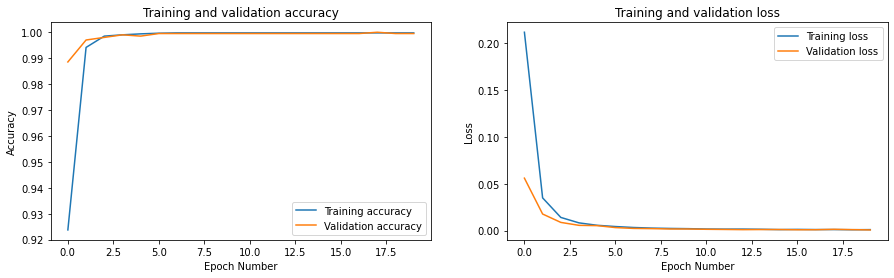

In [11]:
fig = plt.figure(figsize=(15,4))
fig.add_subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

fig.add_subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and validation loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [12]:
model.evaluate(x_test, y_test)

732/732 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9997


[0.0010502736549824476, 0.9997010231018066]

# Класифікація зображень

https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

In [13]:
files=[]
types=[]
codes=[]

In [14]:
def createData(folder, i):
    for filename in os.listdir(folder):
        files.append(filename)
        types.append(folder)
        codes.append(i)

In [15]:
createData('Coast',0)
createData('Desert',1)
createData('Forest',2)
createData('Glacier',3)
createData('Mountain',4)


In [16]:
data = {
  "filename": files,
  "type": types,
  "code": codes,
}

data_array = pd.DataFrame(data)

In [17]:
data_array

,filename,type,code
0,Coast-Train (1).jpeg,Coast,0
1,Coast-Train (10).jpeg,Coast,0
2,Coast-Train (100).jpeg,Coast,0
3,Coast-Train (1000).jpeg,Coast,0
4,Coast-Train (1001).jpeg,Coast,0
...,...,...,...
9995,Mountain (4971).jpeg,Mountain,4
9996,Mountain (4972).jpeg,Mountain,4
9997,Mountain (4973).jpeg,Mountain,4
9998,Mountain (4974).jpeg,Mountain,4


In [18]:
Counter(data_array['type'])

Counter({'Coast': 2000,
         'Desert': 2000,
         'Forest': 2000,
         'Glacier': 2000,
         'Mountain': 2000})

<AxesSubplot:xlabel='type', ylabel='count'>

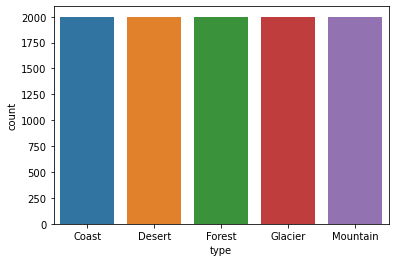

In [19]:
sns.countplot(x='type', data=data_array)

In [20]:
types=['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']
examples=[]
for i in range(5):
    examples.append(data_array['filename'][i*2000])

In [21]:
x = []
for i in range(len(examples)):
    path=types[i]+"/"+ examples[i]
    image = io.imread(path)
    image_res = resize(image, (150, 150), anti_aliasing=True)
    np_pic = np.array(image_res, dtype=np.float32)/255
    x.append(np_pic)

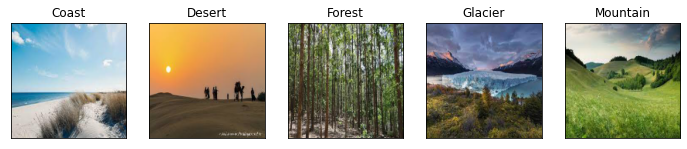

In [22]:
fig = plt.figure(figsize=(12,60))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.set_title(types[i])     
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x[i]*255)

In [23]:
x = []
y=data_array['code']
for i in range(len(data_array['filename'])):
    path=data_array['type'][i]+"/"+ data_array['filename'][i]
    image = io.imread(path)
    image_res = resize(image, (150, 150), anti_aliasing=True)
    np_pic = np.array(image_res, dtype=np.float32)
    x.append(np_pic)

In [24]:
np.save('landscape.npy', x)

In [25]:
x = np.load('landscape.npy')

In [26]:
x=np.asarray(x)

In [27]:
x.shape

(10000, 150, 150, 3)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [29]:
alpha = 0.02

model = keras.Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(150,150,3)))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))

model.add(Flatten())

model.add(Dense(64))

model.add(Dense(5, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 150, 150, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 75, 75, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                  

In [30]:
y_train=np.asarray(y_train).astype(np.int32)
y_test=np.asarray(y_test).astype(np.int32)

In [31]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=1)

Epoch 1/10
200/200 [==============================] - 87s 430ms/step - loss: 1.0073 - accuracy: 0.6136 - val_loss: 1.0203 - val_accuracy: 0.6469
Epoch 2/10
200/200 [==============================] - 92s 461ms/step - loss: 0.8243 - accuracy: 0.6855 - val_loss: 0.9028 - val_accuracy: 0.6556
Epoch 3/10
200/200 [==============================] - 103s 515ms/step - loss: 0.7599 - accuracy: 0.7163 - val_loss: 0.7914 - val_accuracy: 0.7013
Epoch 4/10
200/200 [==============================] - 103s 514ms/step - loss: 0.7101 - accuracy: 0.7295 - val_loss: 0.8255 - val_accuracy: 0.6944
Epoch 5/10
200/200 [==============================] - 100s 502ms/step - loss: 0.6686 - accuracy: 0.7477 - val_loss: 0.8640 - val_accuracy: 0.6969
Epoch 6/10
200/200 [==============================] - 79s 397ms/step - loss: 0.6155 - accuracy: 0.7730 - val_loss: 0.9418 - val_accuracy: 0.6425
Epoch 7/10
200/200 [==============================] - 74s 371ms/step - loss: 0.5298 - accuracy: 0.8028 - val_loss: 0.9106 - val

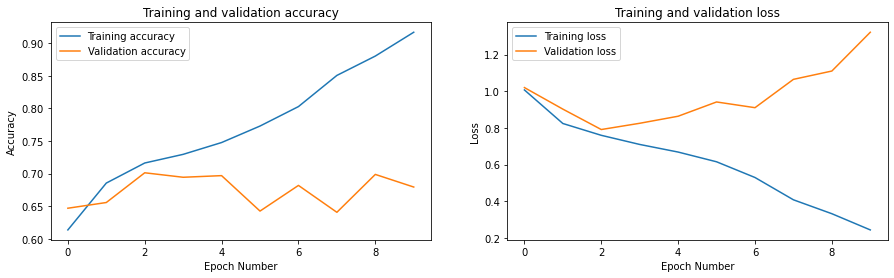

In [32]:
fig = plt.figure(figsize=(15,4))
fig.add_subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

fig.add_subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and validation loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [33]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 7s 114ms/step - loss: 1.3441 - accuracy: 0.6775


[1.3441237211227417, 0.6775000095367432]

# Класифікація текстів

https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?select=twitter_training.csv

In [34]:
data_array = pd.read_csv('twitter_training.csv',delimiter=',', header=None)

In [35]:
del data_array[0]
del data_array[1]
data_array=data_array.dropna()
data_array=data_array[data_array[2]!='Irrelevant']
label_encoder = LabelEncoder()
data_array[2]= label_encoder.fit_transform(data_array[2])
data_array

,2,3
0,2,im getting on borderlands and i will murder yo...
1,2,I am coming to the borders and I will kill you...
2,2,im getting on borderlands and i will kill you ...
3,2,im coming on borderlands and i will murder you...
4,2,im getting on borderlands 2 and i will murder ...
...,...,...
74677,2,Just realized that the Windows partition of my...
74678,2,Just realized that my Mac window partition is ...
74679,2,Just realized the windows partition of my Mac ...
74680,2,Just realized between the windows partition of...


In [36]:
for message in data_array[3]:
    message = message.lower()
    message = re.sub('[%s]' % re.escape(string.punctuation), ' ', message)
    message = re.sub('\s{2,}', " ", message)
    stop_words = stopwords.words("english")
    message = ' '.join([word for word in message.split(' ') if word not in stop_words])

In [37]:
num_words = 10000
max_article_length=750
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data_array[3])
x = tokenizer.texts_to_sequences(data_array[3])
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_article_length)
y = data_array[2]

In [38]:
model = keras.Sequential()
model.add(Embedding(input_dim=num_words, output_dim = 64, input_length=max_article_length))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(3, activation='softmax'))

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 750, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 750, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 706,243
Trainable params: 706,243
Non-trainable params: 0
_________________________________________________________________


In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.5)

In [42]:
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    validation_split=0.2,
                    verbose = 1)

Epoch 1/5
764/764 [==============================] - 419s 544ms/step - loss: 0.7879 - accuracy: 0.6530 - val_loss: 0.6418 - val_accuracy: 0.7358
Epoch 2/5
764/764 [==============================] - 439s 575ms/step - loss: 0.4673 - accuracy: 0.8174 - val_loss: 0.5301 - val_accuracy: 0.7940
Epoch 3/5
764/764 [==============================] - 455s 596ms/step - loss: 0.3087 - accuracy: 0.8835 - val_loss: 0.5111 - val_accuracy: 0.8135
Epoch 4/5
764/764 [==============================] - 477s 625ms/step - loss: 0.2227 - accuracy: 0.9171 - val_loss: 0.5091 - val_accuracy: 0.8259
Epoch 5/5
764/764 [==============================] - 509s 666ms/step - loss: 0.1702 - accuracy: 0.9335 - val_loss: 0.5752 - val_accuracy: 0.8189


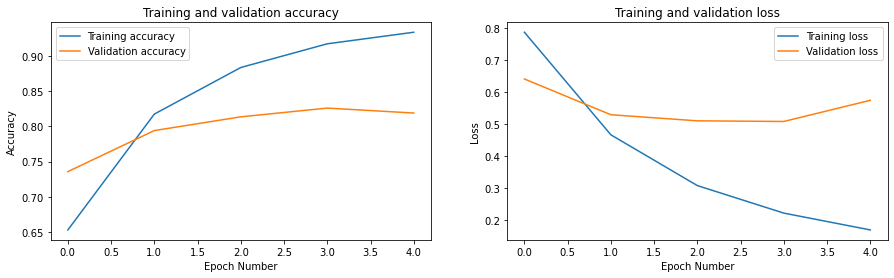

In [43]:
fig = plt.figure(figsize=(15,4))
fig.add_subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')

fig.add_subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and validation loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [44]:
model.evaluate(x_test, y_test)

956/956 [==============================] - 191s 199ms/step - loss: 0.5564 - accuracy: 0.8273


[0.5564054250717163, 0.8273289203643799]